In [33]:
# IMporting all the libraries to be used
import kagglehub
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from xgboost import XGBClassifier

from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [4]:
#Downloading the data from kaggle
data = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print("Path to dataset files:", data)

Resuming download from 3145728 bytes (66009944 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/mlg-ulb/creditcardfraud?dataset_version_number=3 (3145728/69155672) bytes left.


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 66.0M/66.0M [07:26<00:00, 148kB/s] 

Extracting files...


Path to dataset files: /Users/vishnu.a.kumar/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3


In [5]:
#Reading the data locally
data = pd.read_csv('/Users/vishnu.a.kumar/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3/creditcard.csv',sep=',')
data.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## Exploratory Data Analysis

**Exploratory Data Analysis (EDA)** is the process of analyzing and visualizing datasets to summarize their main characteristics, uncover patterns, detect anomalies, test assumptions, and check data quality before applying any machine learning or statistical modeling.
It typically involves:
* Understanding the distribution of data,
* Identifying missing values, outliers, and data types,
* Exploring relationships between variables using plots and statistics.


In [7]:
data.isnull().values.any()

False

/var/folders/kp/w5l0qn1937bbb5bbjbvb3lwc0000gn/T/ipykernel_75585/3628191279.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(data['Class'], sort=True)


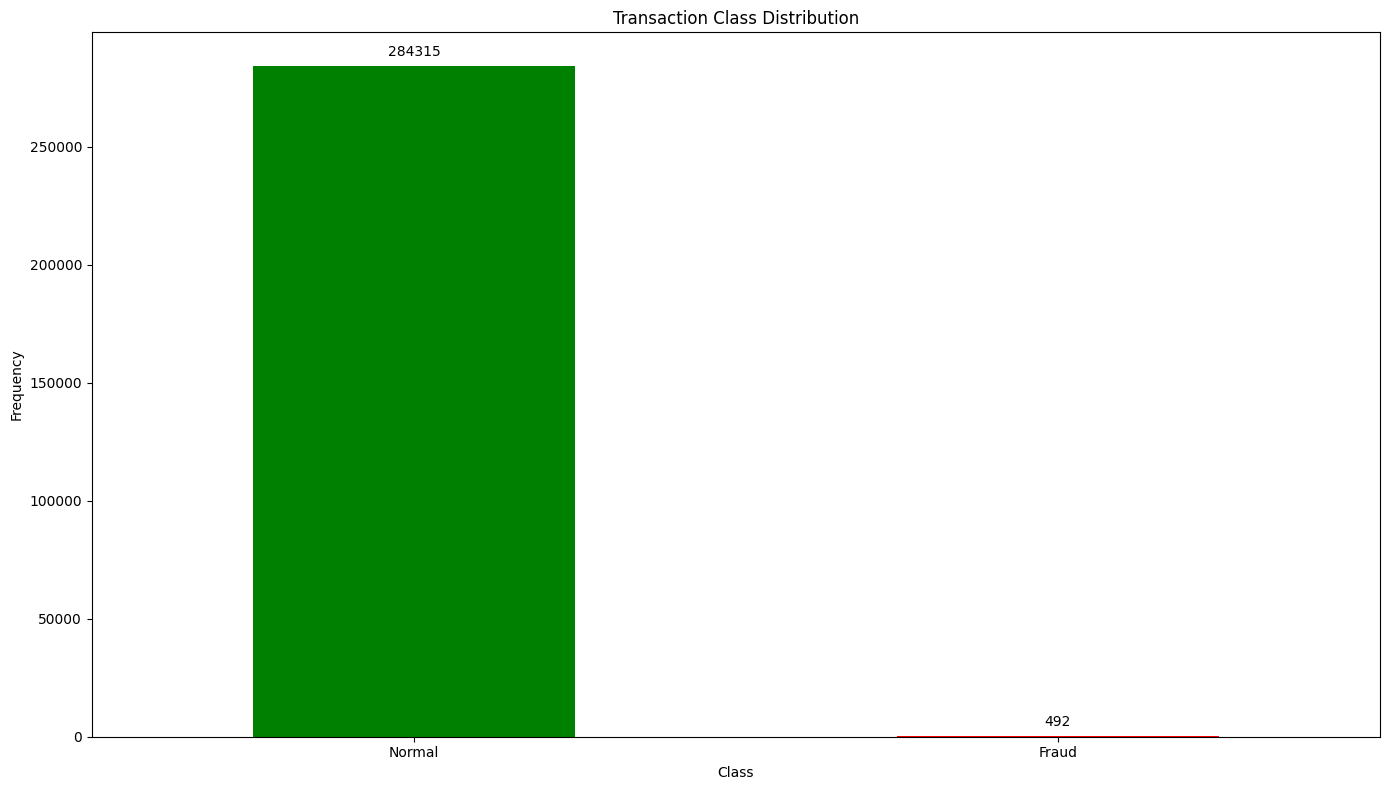

In [8]:
count_classes = pd.value_counts(data['Class'], sort=True)
LABELS = ['Normal', 'Fraud']
COLORS = ['green', 'red'] 

ax = count_classes.plot(kind='bar', color=COLORS, rot=0)

plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

for i, count in enumerate(count_classes):
    plt.text(i, count + max(count_classes) * 0.01, str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [9]:
## Get the Fraud and the normal dataset 

fraud = data[data['Class']==1]

normal = data[data['Class']==0]

In [10]:
print(fraud.shape,normal.shape)

(492, 31) (284315, 31)


In [20]:
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [21]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

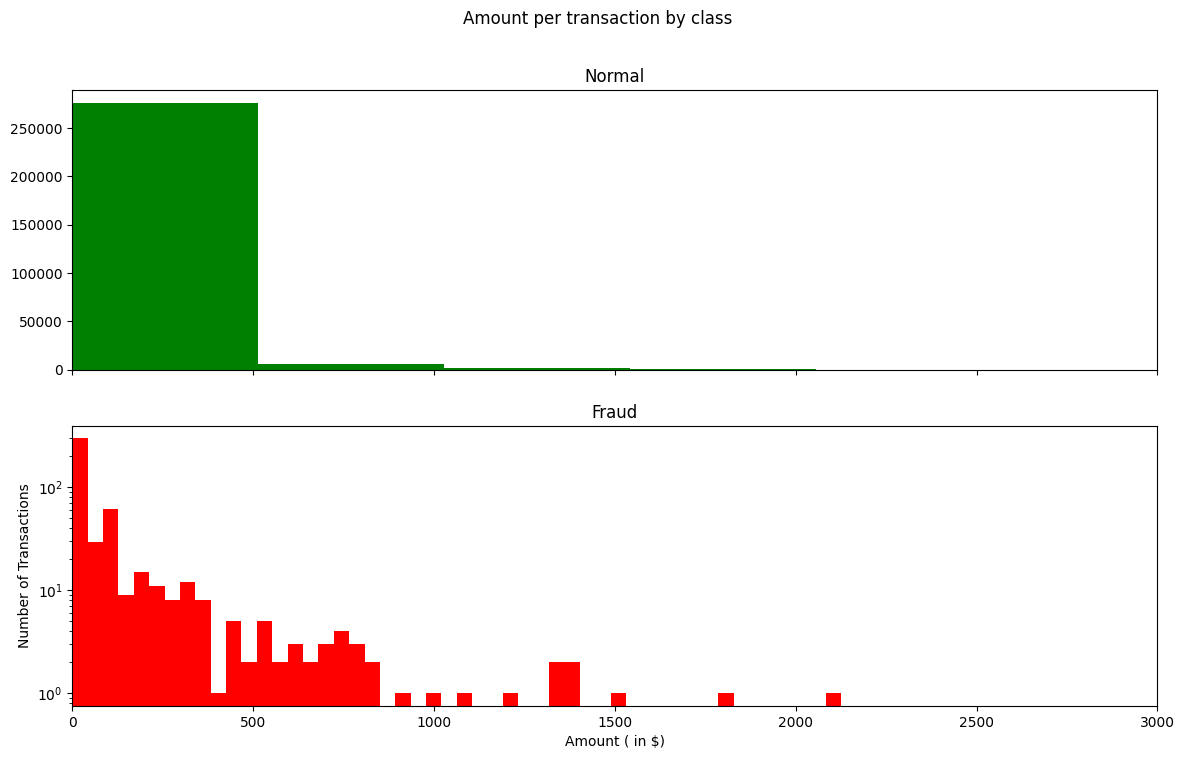

In [22]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(normal.Amount, bins = bins, color = 'green')
ax1.set_title('Normal')
ax2.hist(fraud.Amount, bins = bins, color = 'red')
ax2.set_title('Fraud')
plt.xlabel('Amount ( in $)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 3000))
plt.yscale('log')
plt.show();

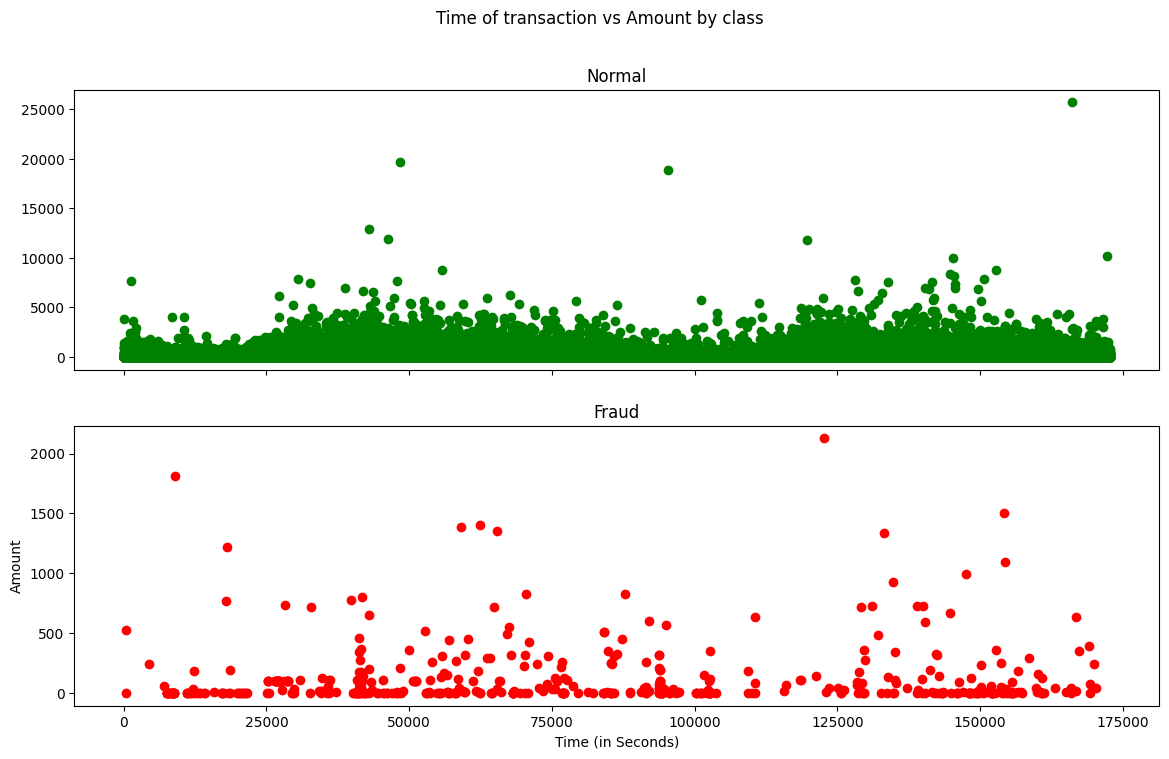

In [23]:
# We Will check Do fraudulent transactions occur more often during certain time frame ? Let us find out with a visual representation.

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(normal.Time, normal.Amount, color = "green")
ax1.set_title('Normal')
ax2.scatter(fraud.Time, fraud.Amount, color = "red")
ax2.set_title('Fraud')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [24]:
## Take some sample of the data

data1= data.sample(frac = 0.1,random_state=1)
data1.shape

(28481, 31)

In [25]:
data.shape

(284807, 31)

In [26]:
#Determine the number of fraud and valid transactions in the dataset

Fraud = data1[data1['Class']==1]

Valid = data1[data1['Class']==0]

outlier_fraction = len(Fraud)/float(len(Valid))

In [27]:
print(outlier_fraction)

print("Fraud Cases : {}".format(len(Fraud)))

print("Valid Cases : {}".format(len(Valid)))

0.0017234102419808666
Fraud Cases : 49
Valid Cases : 28432


In [28]:
#Create independent and Dependent Features
columns = data1.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X = data1[columns]
Y = data1[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(28481, 30)
(28481,)


Now we will fit the model and train it with out data and check the predictions, we will use Isolation Forest, LOF and SVMs. Theoretically speaking Isolation Forest will be giving the best results as it can distribute wights appropriately in cases of outliers in data for best fitting. Here is a brief summary of all these models.

## Isolation Forest
Isolation Forest is an efficient algorithm specifically designed for anomaly detection. It works by isolating anomalies instead of profiling normal data. It randomly selects features and split values to build isolation trees, making anomalies easier to isolate due to their rarity and dissimilarity.
* Key advantages:
    * Works well with imbalanced datasets.
    * Linear time complexity and low memory usage.
    * Requires fewer data samples for effective training.
    * Naturally gives less weight to outliers, helping to reduce their influence on the model.

## Local Outlier Factor (LOF)
LOF is an unsupervised density-based anomaly detection method. It identifies outliers by measuring the local density of each point relative to its neighbors.
* How it works:
    * A point is flagged as an outlier if it has significantly lower density than its neighbors.
    * The n_neighbors parameter controls how local the density comparison is.
* Best used when:
    * Detecting subtle anomalies in local clusters

## Support Vector Machine (SVM) ‚Äì One-Class SVM
One-Class SVM is a variation of the SVM algorithm adapted for novelty detection. It learns the boundary of the normal class and flags anything outside as an anomaly.
* How it works:
    * Fits a decision function around the normal data in high-dimensional space.
    * Outliers are identified as points falling outside this boundary.
* Limitations:
    * Computationally expensive with large datasets.
    * Sensitive to parameter tuning.
    * Can suffer in extremely imbalanced settings.

## XGBoost (Extreme Gradient Boosting)
XGBoost is a powerful, supervised machine learning algorithm based on gradient-boosted decision trees. It‚Äôs widely used for structured/tabular data and has won numerous data science competitions due to its performance and flexibility.
* How it works:
    * Builds an ensemble of decision trees sequentially, where each new tree corrects the errors of the previous ones.
    * Uses gradient descent to minimize loss, optimizing both accuracy and speed.
* Key advantages:
    * Handles missing values and noisy data effectively.
    * Offers regularization to reduce overfitting.
    * Highly scalable and parallelizable, making it suitable for large datasets.
    * Supports both classification and regression tasks.
* Limitations:
    * Being a supervised model, it requires labeled data (i.e., known fraud vs. non-fraud cases).
    * Not directly suitable for anomaly detection unless labels are available and balanced carefully.



In [36]:
classifiers = {
    "Isolation Forest": IsolationForest(max_samples=len(X), contamination=outlier_fraction, random_state=1),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=20, contamination=outlier_fraction),
    "Support Vector Machine": OneClassSVM(kernel='rbf', gamma=0.1, nu=0.05) 
}

In [37]:
from sklearn.metrics import classification_report, accuracy_score

n_outliers = len(Fraud)

for clf_name, clf in classifiers.items():
    print(f"\n{clf_name}:")
    
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
        y_pred = np.where(y_pred == 1, 0, 1) 

    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
        y_pred = np.where(y_pred == 1, 0, 1) 

    elif clf_name == "XGBoost Classifier":
        clf.fit(X, Y)
        y_pred = clf.predict(X)  

    else: 
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
        y_pred = np.where(y_pred == 1, 0, 1) 

    n_errors = (y_pred != Y).sum()
    print(f"Detected Errors: {n_errors}")
    print("Accuracy Score:")
    print(accuracy_score(Y, y_pred))
    print("Classification Report:")
    print(classification_report(Y, y_pred))



Isolation Forest:
Detected Errors: 71
Accuracy Score:
0.99750711000316
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.28      0.29      0.28        49

    accuracy                           1.00     28481
   macro avg       0.64      0.64      0.64     28481
weighted avg       1.00      1.00      1.00     28481


Local Outlier Factor:
Detected Errors: 97
Accuracy Score:
0.9965942207085425
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.02      0.02      0.02        49

    accuracy                           1.00     28481
   macro avg       0.51      0.51      0.51     28481
weighted avg       1.00      1.00      1.00     28481


Support Vector Machine:
Detected Errors: 8516
Accuracy Score:
0.7009936448860644
Classification Report:
              precision    recall  f1-score  

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# Make predictions on the test set
y_pred = model.predict(X_test)
n_errors = (y_pred != y_test).sum()

# Print results in similar format as above
print("XGBoost Classifier:")
print(f"Detected Errors: {n_errors}")
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


/Users/vishnu.a.kumar/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [07:50:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classifier:
Detected Errors: 4
Accuracy Score:
0.9992978760751272
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5690
           1       0.80      0.57      0.67         7

    accuracy                           1.00      5697
   macro avg       0.90      0.79      0.83      5697
weighted avg       1.00      1.00      1.00      5697



## Oservations:
üîé Anomaly Detection Results:
* Isolation Forest detected 71 anomalies,
* Local Outlier Factor (LOF) detected 97 anomalies,
* Support Vector Machine (SVM) flagged a massive 8,516 transactions as errors,
* XGBoost Classifier detected 4 errors, indicating it misclassified 4 instances on the test set.

‚úÖ Accuracy Comparison:
* XGBoost achieved the highest accuracy at 99.93%,
* Isolation Forest closely followed at 99.75%,
* LOF had slightly lower performance at 99.66%,
* SVM had a significant drop in performance with 70.09% accuracy.

‚ö†Ô∏è Fraud Detection Performance (Class 1 ‚Äì Fraud Cases):
* XGBoost:
    * Precision: 0.80
    * Recall: 0.57
    * F1-score: 0.6: 7It performed best overall, though with a slightly lower recall than ideal.
* Isolation Forest:
    * Recall: 29% ‚Äì decent performance for an unsupervised method.
* LOF:
    * Recall: 2% ‚Äì extremely weak fraud detection capability.
* SVM:
    * Recall: 37%, but precision was 0%, indicating all flagged frauds were false positives.

üìä Precision & Recall Insight:
* XGBoost struck a good balance with 80% precision and 57% recall ‚Äî a high-confidence model for fraud detection with few false alarms.
* Isolation Forest managed moderate detection ability, with meaningful predictions in an unsupervised setup.
* LOF and SVM struggled with poor precision and recall, making them unreliable for fraud detection in this case.

üß† Conclusion:
* XGBoost is the top-performing model in this evaluation, with near-perfect accuracy and strong fraud detection capabilities, even though it slightly underperformed on recall for frauds (likely due to class imbalance).
* Isolation Forest remains a strong unsupervised alternative, useful in real-world scenarios where labeled data is scarce.
* LOF and SVM underperformed, especially in identifying frauds, and are not ideal choices for highly imbalanced fraud detection problems.
    * 


